### Part A - Loading the CSV

In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv("diff.csv")
df.columns

Index(['Hash', 'Message', 'Filename', 'Source Code (prev)',
       'Source Code (current)', 'Diff', 'LLM Inference', 'rectified message'],
      dtype='object')

In [3]:
df.head(2)

,Hash,Message,Filename,Source Code (prev),Source Code (current),Diff,LLM Inference,rectified message
0,b51eb87b4bce896550a647562a9526b34603eab9,Added possibility to write MOT compliant resul...,track.py,import argparse\nimport os\nimport platform\ni...,import argparse\nimport os\nimport platform\ni...,"@@ -114,6 +114,10 @@ def detect(opt, save_img=...",update webcam detection script,Added STORM - 236 to Changelog
1,21bc8b50d5727207b0fc2ca44f0cb2c98db9c542,Fixed video save bug,track.py,"from yolov5.utils.datasets import LoadImages, ...","from yolov5.utils.datasets import LoadImages, ...","@@ -50,11 +50,11 @@ def draw_boxes(img, bbox, ...",improve image detection,Add forced default for type to oCC 2


### Total number of hashes and files

In [4]:
print(f"Total number of hashes are {len(df["Hash"])}, while the unique number hashes are {df["Hash"].nunique()}")
print(f"Total number of Files are {df["Filename"].nunique()} which have changed in thim.")

Total number of hashes are 727, while the unique number hashes are 388
Total number of Files are 247 which have changed in thim.


### Average number of files per commit

In [5]:
dict = {}
for index, row in df.iterrows():
    if row["Hash"] not in dict:
        dict[row["Hash"]] = 1
    else:
        dict[row["Hash"]] += 1

avg_value = 0

for _, count in dict.items():
    avg_value += count

avg_value /= len(dict)
print(f"Average number of modified files per commit: {avg_value}")
del dict

Average number of modified files per commit: 1.8737113402061856


### Distribution of fix types

In [6]:
import pandas as pd
from collections import defaultdict; 

fix_types = {
    "add": ["add", "create"],
    "update": ["update", "upgrade", "refactor", "restructure", "clean", "optimize", "improve", "enhance", "performance"],
    "remove": ["remove", "delete", "drop"],
    "fix": ["fix", "bug", "error", "correct"],
    "docs": ["docs", "documentation", "readme"],
    "test": ["test", "tests", "config", "build"]
}
mappings = {s2: m for m, s in fix_types.items() for s2 in s}
for m, s in fix_types.items():
    for s2 in s:
        mappings[s2] = m


def classify(commit_message):
    words = commit_message.lower().split()
    for word in words:
        if word in mappings:
            return [mappings[word]]
    return []

def counttype(df, column):
    count_lst = defaultdict(int)
    for msg in df[column].dropna():
        typematch = classify(msg)
        for t in typematch:
            count_lst[t] += 1
    return dict(count_lst)

counts = counttype(df, "LLM Inference")
print("Fix type distribution:", counts)

Fix type distribution: {'update': 497, 'add': 191, 'fix': 37, 'remove': 1}


#### Plot for distribution of fix types

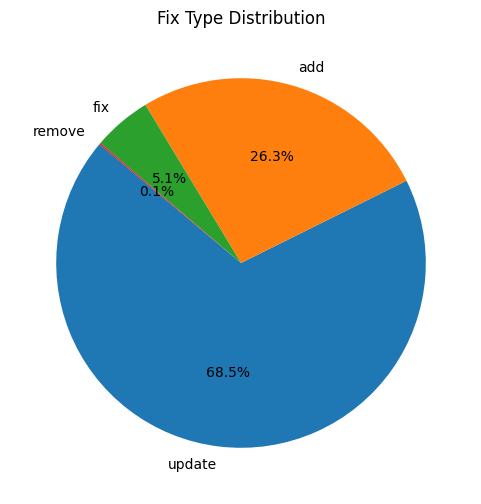

In [8]:
import matplotlib.pyplot as plt
plt.figure(figsize=(6, 6))
plt.pie(counts.values(), labels=counts.keys(), autopct="%1.1f%%", startangle=140)
plt.title("Fix Type Distribution")
plt.show()

### Most frequently modified filenames/extensions

In [10]:
import os
import matplotlib.pyplot as plt
from collections import Counter

def extret(filename):
    return os.path.splitext(filename)[1] if "." in filename else "no_ext"

def freqmax(df, column="filename", top_n=10):
    files = df[column].dropna().tolist()
    file_counts = Counter(files)
    ext_counts = Counter(extret(f) for f in files)

    return file_counts.most_common(top_n), ext_counts.most_common(top_n)


file_counts, ext_counts = freqmax(df, column="Filename")

print("📂 Top modified filenames:")
for f, c in file_counts:
    print(f"{f} → {c}")

print("\n📝 Top modified extensions:")
for e, c in ext_counts:
    print(f"{e} → {c}")

📂 Top modified filenames:
tracking/val.py → 40
track.py → 32
boxmot/utils/__init__.py → 24
val.py → 14
boxmot/trackers/botsort/bot_sort.py → 14
boxmot/appearance/reid_export.py → 13
tracking/evolve.py → 13
.github/workflows/ci.yml → 11
boxmot/appearance/reid_multibackend.py → 11
boxmot/trackers/bytetrack/byte_tracker.py → 11

📝 Top modified extensions:
.py → 699
.yml → 14
.yaml → 6
 → 2
.toml → 2
.txt → 1
.gz → 1
.lock → 1
.md → 1


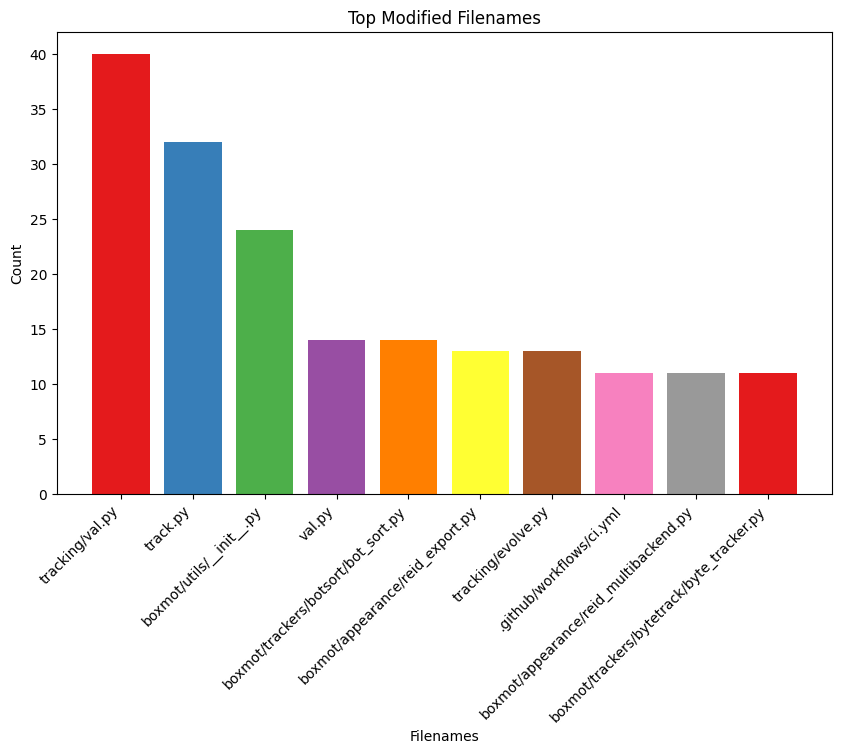

In [11]:
file_names, file_freqs = zip(*file_counts)

plt.figure(figsize=(10, 6))
plt.bar(file_names, file_freqs, color=plt.cm.Set1.colors)
plt.xticks(rotation=45, ha="right")
plt.title("Top Modified Filenames")
plt.xlabel("Filenames")
plt.ylabel("Count")
plt.show()

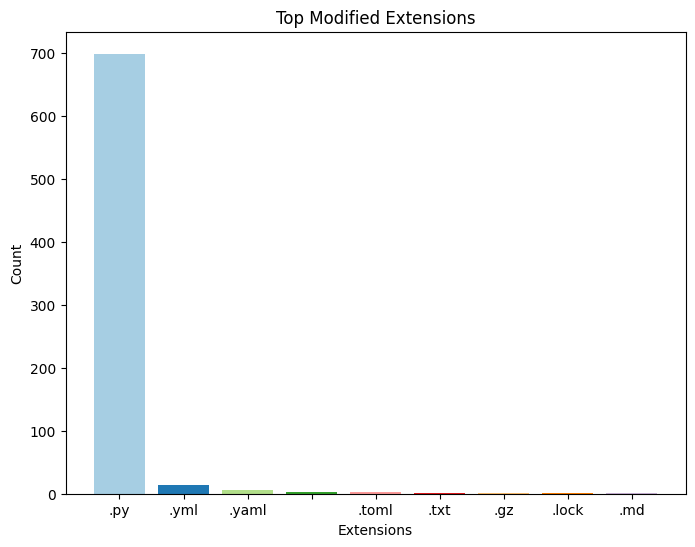

In [12]:
ext_names, ext_freqs = zip(*ext_counts)

plt.figure(figsize=(8, 6))
plt.bar(ext_names, ext_freqs, color=plt.cm.Paired.colors)
plt.title("Top Modified Extensions")
plt.xlabel("Extensions")
plt.ylabel("Count")
plt.show()

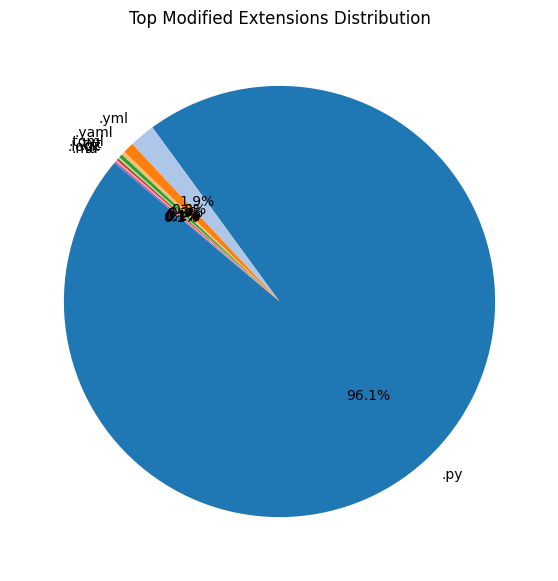

In [13]:
plt.figure(figsize=(7, 7))
plt.pie(ext_freqs, labels=ext_names, autopct="%1.1f%%", colors=plt.cm.tab20.colors, startangle=140)
plt.title("Top Modified Extensions Distribution")
plt.show()

### Part C - Structural Metrics with Radon

In [ ]:
import pandas as pd; import numpy as np
from radon.raw import analyze as analyze_loc
from radon.metrics import mi_visit
from radon.complexity import cc_visit
import re, os, subprocess

REPO_PATH = "/Users/tejasmacipad/Desktop/Third_year/STT/lab2/boxmot"
df = pd.read_csv('diff.csv')

def codefetch(commit_hash, filepath, use_parent=False):
    git_spec = f"{commit_hash}^:{filepath}" if use_parent else f"{commit_hash}:{filepath}"
    command = ['git', 'show', git_spec]

    try:
        result = subprocess.run(
            command,
            cwd=REPO_PATH,
            capture_output=True,
            text=True,
            encoding='utf-8',
            errors='ignore',
            check=False
        )

        if result.returncode == 0:
            return result.stdout
        else:
            return ""
    except:
        print(f"error in {commit_hash} and {filepath}")

def radonmet(source_code):
    if not isinstance(source_code, str) or not source_code.strip():
        return np.nan, np.nan, np.nan

    cleaned_code = source_code.encode('ascii', 'ignore').decode('utf-8')

    try:
        loc = analyze_loc(cleaned_code).sloc
        mi = mi_visit(cleaned_code, multi=True)
        cc_results = cc_visit(cleaned_code)
        total_cc = sum(block.complexity for block in cc_results)
        return mi, total_cc, loc
    except Exception as e:
        return np.nan, np.nan, np.nan

metrics_before = []
metrics_after = []

for index, row in df.iterrows():

    commit_hash = row['Hash']
    filename = row['Filename']
    code_before = codefetch(commit_hash, filename, use_parent=True)
    code_after = codefetch(commit_hash, filename)
    metrics_before.append(radonmet(code_before))
    metrics_after.append(radonmet(code_after))


df[['MI_Before', 'CC_Before', 'LOC_Before']] = metrics_before
df[['MI_After', 'CC_After', 'LOC_After']] = metrics_after


df['MI_Change'] = df['MI_After'] - df['MI_Before']
df['CC_Change'] = df['CC_After'] - df['CC_Before']
df['LOC_Change'] = df['LOC_After'] - df['LOC_Before']



display_cols = [
    'Hash', 'Filename', 'MI_Before', 'MI_After', 'MI_Change',
    'CC_Before', 'CC_After', 'CC_Change',
    'LOC_Before', 'LOC_After', 'LOC_Change'
]
if 'Filename' not in df.columns:
    display_cols.remove('Filename')

print(df[display_cols].to_string())
metric_cols = ['MI_Before', 'CC_Before', 'LOC_Before', 'MI_After', 'CC_After','LOC_After', 'MI_Change', 'CC_Change', 'LOC_Change']
cleaned_df = df.dropna(subset=metric_cols)
output_filename = 'diffprocessed.csv'
cleaned_df.to_csv(output_filename, index=False)

### Part D - Change Magnitude Metrics

#### Similarity between tokens generated by CodeBERT

In [ ]:
import pandas as pd
import subprocess
from sentence_transformers import SentenceTransformer, util
import torch

repo_path = "/Users/tejasmacipad/Desktop/Third_year/STT/lab2/boxmot"
csv_path = "diffprocessed.csv"

df = pd.read_csv(csv_path)

model = SentenceTransformer("microsoft/codebert-base")
device = "cuda" if torch.cuda.is_available() else ("mps" if torch.backends.mps.is_available() else "cpu")
model.to(device)

df["CodeBERT_Similarity"] = 0.0

def file_at_commit(commit_hash, filepath):
    if not commit_hash:
        return ""
    try:
        cmd = ["git", "-C", repo_path, "show", f"{commit_hash}:{filepath}"]
        result = subprocess.run(cmd, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)
        if result.returncode == 0:
            return result.stdout
    except Exception:
        pass
    return ""

for i, row in df.iterrows():
    h = str(row["Hash"])
    fname = str(row["Filename"])
    curr_code = file_at_commit(h, fname)
    parent_cmd = ["git", "-C", repo_path, "rev-list", "--parents", "-n", "1", h]
    result = subprocess.run(parent_cmd, stdout=subprocess.PIPE, text=True)
    parts = result.stdout.strip().split()
    parent_h = parts[1] if len(parts) > 1 else None
    prev_code = file_at_commit(parent_h, fname)
    emb = model.encode([prev_code, curr_code], convert_to_tensor=True, normalize_embeddings=True, device=device)
    sim = util.pytorch_cos_sim(emb[0], emb[1]).item()
    df.at[i, "CodeBERT_Similarity"] = float(sim)
    if i % 25 == 0:
        print(f"{i}/{len(df)}")

out_csv = "diffprocessed.csv"
df.to_csv(out_csv, index=False)
print("done ->", out_csv)

In [14]:
import pandas as pd
temp2 = pd.read_csv("diffprocessed.csv")
temp2.columns

Index(['Hash', 'Message', 'Filename', 'Source Code (prev)',
       'Source Code (current)', 'Diff', 'LLM Inference', 'rectified message',
       'MI_Before', 'CC_Before', 'LOC_Before', 'MI_After', 'CC_After',
       'LOC_After', 'MI_Change', 'CC_Change', 'LOC_Change',
       'CodeBERT_Similarity', 'BLEU_Similarity', 'Semantic_class',
       'Classes_Agree', 'Token_class'],
      dtype='object')

In [15]:
print(f"Average of Maintainibility Index before: {temp2["MI_Before"].mean()}")
print(f"Average of Maintainibility Index after: {temp2["MI_After"].mean()}")
print(f"Average of Cyclomatic complexity before: {temp2["CC_Before"].mean()}")
print(f"Average of Cyclomatic complexity after: {temp2["CC_After"].mean()}")
print(f"Average of LOC before: {temp2["LOC_Before"].mean()}")
print(f"Average of LOC after: {temp2["LOC_After"].mean()}")

print(f"Average MI change: {temp2['MI_Change'].mean()}")
print(f"Average CC change: {temp2['CC_Change'].mean()}")
print(f"Average LOC change: {temp2['LOC_Change'].mean()}")

Average of Maintainibility Index before: 55.322437804822876
Average of Maintainibility Index after: 55.0618077795946
Average of Cyclomatic complexity before: 40.45757575757576
Average of Cyclomatic complexity after: 40.57272727272727
Average of LOC before: 178.80151515151516
Average of LOC after: 181.19545454545454
Average MI change: -0.2606300252282696
Average CC change: 0.11515151515151516
Average LOC change: 2.393939393939394


In [16]:
temp = pd.read_csv("diffprocessed.csv")
row = temp["CodeBERT_Similarity"]
print(row.mean())
row = temp["BLEU_Similarity"]
print(row.mean())

0.9995073082772168
0.9267267797885531


### Similarity between source codes using BLEU

In [ ]:
import pandas as pd
import nltk
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
nltk.download("punkt")

csv_path = "diffprocessed.csv"
df = pd.read_csv(csv_path)



df["BLEU_Similarity"] = 0.0

smooth_fn = SmoothingFunction().method1

for i, row in df.iterrows():
    prev_code = str(row["Source Code (prev)"])
    curr_code = str(row["Source Code (current)"])

    prev_tokens = prev_code.split()
    curr_tokens = curr_code.split()

    if prev_tokens and curr_tokens:
        bleu = sentence_bleu([prev_tokens], curr_tokens, smoothing_function=smooth_fn)
    else:
        bleu = 0.0

    df.at[i, "BLEU_Similarity"] = bleu

    if i % 25 == 0:
        print(f"{i}/{len(df)} processed...")

out_csv = "diffprocessed.csv"
df.to_csv(out_csv, index=False)
print("done ->", out_csv)

In [17]:
df = pd.read_csv("diffprocessed.csv")
df.columns
df["BLEU_Similarity"].mean()

np.float64(0.9267267797885531)

### Part E - Classification & Agreement:

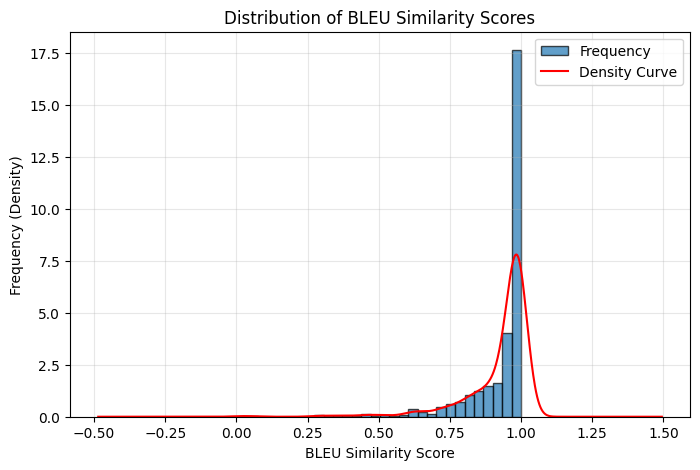

In [19]:
import matplotlib.pyplot as plt
temp = pd.read_csv("diffprocessed.csv").copy()
col = temp["BLEU_Similarity"]
plt.figure(figsize=(8,5))
plt.hist(col, bins=30, edgecolor="black", alpha=0.7, density=True, label="Frequency")
col.plot(kind="kde", color="red", label="Density Curve")
plt.xlabel("BLEU Similarity Score")
plt.ylabel("Frequency (Density)")
plt.title("Distribution of BLEU Similarity Scores")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

In [21]:
df.columns

Index(['Hash', 'Message', 'Filename', 'Source Code (prev)',
       'Source Code (current)', 'Diff', 'LLM Inference', 'rectified message',
       'MI_Before', 'CC_Before', 'LOC_Before', 'MI_After', 'CC_After',
       'LOC_After', 'MI_Change', 'CC_Change', 'LOC_Change',
       'CodeBERT_Similarity', 'BLEU_Similarity', 'Semantic_class',
       'Classes_Agree', 'Token_class'],
      dtype='object')

In [26]:
import pandas as pd

df["Semantic_class"] = df["BLEU_Similarity"].apply(
    lambda x: "Minor Fix" if x >= 0.80 else "Major Fix"
)
df["Token_class"] = df["CodeBERT_Similarity"].apply(
    lambda x: "Minor Fix" if x >= 0.75 else "Major Fix"
)
df["Classes_Agree"] = df.apply(
    lambda row: "YES" if row["Semantic_class"] == row["Token_class"] else "NO", axis=1
)

print(df[["BLEU_Similarity", "CodeBERT_Similarity", "Semantic_class", "Token_class", "Classes_Agree"]].head(7))

   BLEU_Similarity  CodeBERT_Similarity Semantic_class Token_class  \
0         0.967341             1.000000      Minor Fix   Minor Fix   
1         0.960869             1.000000      Minor Fix   Minor Fix   
2         0.991312             1.000000      Minor Fix   Minor Fix   
3         0.990978             1.000000      Minor Fix   Minor Fix   
4         0.963388             0.999976      Minor Fix   Minor Fix   
5         0.987714             1.000000      Minor Fix   Minor Fix   
6         0.973268             1.000000      Minor Fix   Minor Fix   

  Classes_Agree  
0           YES  
1           YES  
2           YES  
3           YES  
4           YES  
5           YES  
6           YES  


In [28]:
import pandas as pd
df = pd.read_csv("diffprocessed.csv")
df["Classes_Agree"] = df.apply(
    lambda row: "YES" if row["Semantic_class"] == row["Token_class"] else "NO",
    axis=1
)
df.to_csv("diffprocessed.csv", index=False)

print(df[["Semantic_class", "Token_class", "Classes_Agree"]].head())
print(f"Number of commits which are major according to CodeBERT Model {(df["Semantic_class"] == "High").sum()}")
print(f"Number of commits which are major according to Bleu Tokens {(df["Token_class"] == "High").sum()}")
print(f"Number of commits where methods agree {(df["Classes_Agree"] == "YES").sum()}")

  Semantic_class Token_class Classes_Agree
0            Low        High            NO
1            Low        High            NO
2           High        High           YES
3           High        High           YES
4            Low        High            NO
Number of commits which are major according to CodeBERT Model 369
Number of commits which are major according to Bleu Tokens 660
Number of commits where methods agree 369
